# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_512_3200_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_512_3200_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_512_3200_train3.pkl"


Target_dir_train1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_512_3200_train1.pkl")
Target_dir_train2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_512_3200_train2.pkl")
Target_dir_test1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_512_3200_test1.pkl")
Target_dir_test2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_512_3200_test2.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_512_3200_train1.pkl")
Target_cyclegan_dir_train2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_512_3200_train2.pkl")
Target_cyclegan_dir_test1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_512_3200_test1.pkl")
Target_cyclegan_dir_test2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_512_3200_test2.pkl")

In [ ]:
CHANNELS = 3
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

# Loading Dataset

## LC25000 Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)

In [ ]:
# LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] 
# LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label']))
# LC25000_train_data = LC25000_train1['train'][0:400] + LC25000_train2['train'][0:400] + LC25000_train3['train'][0:400] 
# LC25000_train_labels = np.concatenate((LC25000_train1['train_label'][0:400],LC25000_train2['train_label'][0:400],LC25000_train3['train_label'][0:400]))
LC25000_train_data = LC25000_train1['train'][0:533] + LC25000_train2['train'][0:534] + LC25000_train3['train'][0:533] 
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'][0:533],LC25000_train2['train_label'][0:534],LC25000_train3['train_label'][0:533]))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)

In [ ]:
LC25000_train_data = np.array(LC25000_train_data, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", np.shape(LC25000_train_data))
print("The shape of LC25000_train_labels: ", np.shape(LC25000_train_labels))

The shape of LC25000_train_data:  (1600, 512, 512, 3)
The shape of LC25000_train_labels:  (1600,)


In [ ]:
import gc
gc.collect()

300

## TCGA Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_dir_train1), "rb") as f:
    TCGA_train1 = pickle.load(f)
with open(os.path.abspath(Target_dir_train2), "rb") as f:
    TCGA_train2 = pickle.load(f)
# with open(os.path.abspath(Target_dir_test1), "rb") as f:
#     TCGA_test1 = pickle.load(f)
# with open(os.path.abspath(Target_dir_test2), "rb") as f:
#     TCGA_test2 = pickle.load(f)

In [ ]:
# TCGA_train_data = TCGA_train1['train'][0:600] + TCGA_train2['train'][0:600]
# TCGA_train_labels = np.concatenate((TCGA_train1['train_label'][0:600],TCGA_train2['train_label'][0:600]))
TCGA_train_data = TCGA_train1['train'][0:800] + TCGA_train2['train'][0:800]
TCGA_train_labels = np.concatenate((TCGA_train1['train_label'][0:800],TCGA_train2['train_label'][0:800]))
# TCGA_test_data = TCGA_test1['test'][0:300] + TCGA_test2['test'][0:300]
# TCGA_test_labels = np.concatenate((TCGA_test1['test_label'][0:300],TCGA_test2['test_label'][0:300]))

In [ ]:
TCGA_train_lab = tf.one_hot(TCGA_train_labels, depth=3)
# TCGA_test_lab = tf.one_hot(TCGA_test_labels, depth=3)

In [ ]:
TCGA_train_data = np.array(TCGA_train_data, dtype=np.float32)
# TCGA_test_data = np.array(TCGA_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_train_data: ", np.shape(TCGA_train_data))
print("The shape of TCGA_train_labels: ", np.shape(TCGA_train_labels))
# print("The shape of TCGA_test_data: ", np.shape(TCGA_test_data))
# print("The shape of TCGA_test_labels: " , np.shape(TCGA_test_labels))

The shape of TCGA_train_data:  (1600, 512, 512, 3)
The shape of TCGA_train_labels:  (1600,)


In [ ]:
import gc
gc.collect()

250

## Datasets Visualization

<function matplotlib.pyplot.show>

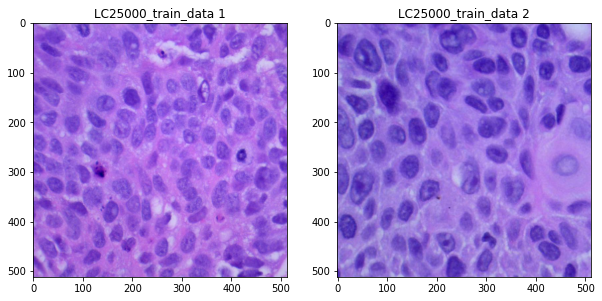

In [ ]:
# random show source images
fig = plt.subplots(1,2,figsize=(10,10))
#plt.suptitle("Source Domain = LC25000", fontsize=18)
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data)
img1 = array_to_img(sample1)
plt.show
plt.title("LC25000_train_data 1")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_train_data)
img2 = array_to_img(sample2)
plt.title("LC25000_train_data 2")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

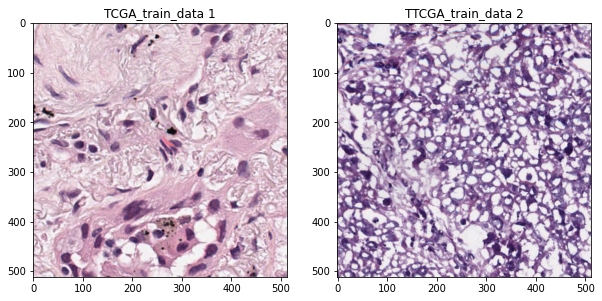

In [ ]:
# random show Target images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_train_data 1")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_train_data)
img2 = array_to_img(sample2)
plt.title("TTCGA_train_data 2")
plt.imshow(img2)
plt.show

# Domain Adaptation

## Build Model

### Feature Extractor - ResNet50V2

In [ ]:
resnet50 = ResNet50(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="avg")

first_layer = resnet50.get_layer('conv5_block2_out')
inputs = Input(first_layer.output_shape[1:])

for layer in resnet50.layers[resnet50.layers.index(first_layer)+1:]:
    if layer.name == "conv5_block3_1_conv":
        x = layer(inputs)
    elif layer.name == "conv5_block3_add":  # change name
        x = layer([inputs, x])
    else:
        if layer.name == "conv5_block3_preact_bn":
            pass
        else:
            x = layer(x)

first_blocks = Model(resnet50.input, first_layer.output)
last_block = Model(inputs, x)

In [ ]:
def load_resnet50(path="./Model/DANN_Model/resnet50_last_block_512.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/resnet50_last_block_512.hdf5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16, 16, 204  0           []                               
                                8)]                                                               
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 16, 16, 512)  1049088     ['input_2[0][0]']                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 16, 16, 512)  2048       ['conv5_block3_1_conv[1][0]']    
 ization)                                                                                         
                                                                                            

### Extract the features 

In [ ]:
import gc
gc.collect()

2516

In [ ]:
LC25000_train_data_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data)))

In [ ]:
gc.collect()

1012

In [ ]:
TCGA_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_train_data)))

In [ ]:
gc.collect()

689

In [ ]:
print("LC25000_train_data (source) shape: %s"%str(LC25000_train_data.shape))
print("TCGA_train_data (target) shape: %s"%str(TCGA_train_data.shape))

LC25000_train_data (source) shape: (1600, 512, 512, 3)
TCGA_train_data (target) shape: (1600, 512, 512, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=50, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
200/200 [==============================] - 7s 28ms/step - loss: 0.4501 - acc: 0.8363 - val_loss: 0.6761 - val_acc: 0.6756
Epoch 2/5
200/200 [==============================] - 5s 25ms/step - loss: 0.1633 - acc: 0.9394 - val_loss: 0.7666 - val_acc: 0.6969
Epoch 3/5
200/200 [==============================] - 4s 21ms/step - loss: 0.1418 - acc: 0.9469 - val_loss: 0.6578 - val_acc: 0.7563
Epoch 4/5
200/200 [==============================] - 4s 21ms/step - loss: 0.1369 - acc: 0.9538 - val_loss: 0.8008 - val_acc: 0.7269
Epoch 5/5
200/200 [==============================] - 4s 21ms/step - loss: 0.1367 - acc: 0.9563 - val_loss: 0.7300 - val_acc: 0.7625
Epoch 1/50
200/200 [==============================] - 11s 40ms/step - loss: 0.1368 - acc: 0.9575 - val_loss: 1.0961 - val_acc: 0.6575
Epoch 2/50
200/200 [==============================] - 6s 32ms/step - loss: 0.1135 - acc: 0.9544 - val_loss: 1.0663 - val_acc: 0.6706
Epoch 3/50
200/200 [==============================] - 6s 31ms/step - loss

### Run 2

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig_1 = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig_1.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=50, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/3
200/200 [==============================] - 7s 30ms/step - loss: 0.4290 - acc: 0.8462 - val_loss: 0.7873 - val_acc: 0.6363
Epoch 2/3
200/200 [==============================] - 4s 22ms/step - loss: 0.1585 - acc: 0.9394 - val_loss: 1.3784 - val_acc: 0.4663
Epoch 3/3
200/200 [==============================] - 4s 21ms/step - loss: 0.1419 - acc: 0.9488 - val_loss: 0.7273 - val_acc: 0.7294
Epoch 1/50
200/200 [==============================] - 10s 35ms/step - loss: 0.1333 - acc: 0.9500 - val_loss: 0.8386 - val_acc: 0.6994
Epoch 2/50
200/200 [==============================] - 6s 28ms/step - loss: 0.1213 - acc: 0.9569 - val_loss: 1.5468 - val_acc: 0.5206
Epoch 3/50
200/200 [==============================] - 5s 27ms/step - loss: 0.1171 - acc: 0.9600 - val_loss: 0.7799 - val_acc: 0.7506
Epoch 4/50
200/200 [==============================] - 5s 27ms/step - loss: 0.0994 - acc: 0.9619 - val_loss: 1.3143 - val_acc: 0.6144
Epoch 5/50
200/200 [==============================] - 5s 27ms/step - lo

### Run 3

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig_2 = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig_2.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=50, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/3
200/200 [==============================] - 7s 29ms/step - loss: 0.4487 - acc: 0.8344 - val_loss: 0.6088 - val_acc: 0.7287
Epoch 2/3
200/200 [==============================] - 5s 26ms/step - loss: 0.1622 - acc: 0.9369 - val_loss: 0.8865 - val_acc: 0.6313
Epoch 3/3
200/200 [==============================] - 4s 22ms/step - loss: 0.1432 - acc: 0.9438 - val_loss: 1.0455 - val_acc: 0.6400
Epoch 1/50
200/200 [==============================] - 9s 35ms/step - loss: 0.1612 - acc: 0.9444 - val_loss: 1.0689 - val_acc: 0.6288
Epoch 2/50
200/200 [==============================] - 5s 27ms/step - loss: 0.1192 - acc: 0.9556 - val_loss: 1.2371 - val_acc: 0.6206
Epoch 3/50
200/200 [==============================] - 5s 27ms/step - loss: 0.1220 - acc: 0.9575 - val_loss: 0.7243 - val_acc: 0.7619
Epoch 4/50
200/200 [==============================] - 5s 27ms/step - loss: 0.1068 - acc: 0.9631 - val_loss: 0.8845 - val_acc: 0.7331
Epoch 5/50
200/200 [==============================] - 5s 27ms/step - los

### Run 4

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig_2 = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig_2.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=50, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/3
200/200 [==============================] - 8s 30ms/step - loss: 0.4421 - acc: 0.8431 - val_loss: 0.7197 - val_acc: 0.6700
Epoch 2/3
200/200 [==============================] - 5s 23ms/step - loss: 0.1702 - acc: 0.9331 - val_loss: 0.8328 - val_acc: 0.6531
Epoch 3/3
200/200 [==============================] - 4s 22ms/step - loss: 0.1274 - acc: 0.9494 - val_loss: 0.9829 - val_acc: 0.6450
Epoch 1/50
200/200 [==============================] - 10s 35ms/step - loss: 0.1483 - acc: 0.9463 - val_loss: 0.5317 - val_acc: 0.8256
Epoch 2/50
200/200 [==============================] - 5s 27ms/step - loss: 0.1218 - acc: 0.9575 - val_loss: 0.9304 - val_acc: 0.6975
Epoch 3/50
200/200 [==============================] - 6s 28ms/step - loss: 0.1133 - acc: 0.9631 - val_loss: 1.0781 - val_acc: 0.6706
Epoch 4/50
200/200 [==============================] - 6s 28ms/step - loss: 0.1216 - acc: 0.9650 - val_loss: 0.7613 - val_acc: 0.7613
Epoch 5/50
200/200 [==============================] - 5s 27ms/step - lo

### Run 5

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)


In [ ]:
finetunig_2 = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig_2.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=50, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/3
200/200 [==============================] - 7s 30ms/step - loss: 0.4695 - acc: 0.8356 - val_loss: 0.4587 - val_acc: 0.8012
Epoch 2/3
200/200 [==============================] - 5s 24ms/step - loss: 0.1609 - acc: 0.9369 - val_loss: 0.8256 - val_acc: 0.6756
Epoch 3/3
200/200 [==============================] - 5s 23ms/step - loss: 0.1517 - acc: 0.9406 - val_loss: 0.8009 - val_acc: 0.7031
Epoch 1/50
200/200 [==============================] - 10s 35ms/step - loss: 0.1514 - acc: 0.9488 - val_loss: 1.1270 - val_acc: 0.6144
Epoch 2/50
200/200 [==============================] - 6s 28ms/step - loss: 0.1260 - acc: 0.9525 - val_loss: 0.6171 - val_acc: 0.7962
Epoch 3/50
200/200 [==============================] - 6s 28ms/step - loss: 0.0900 - acc: 0.9675 - val_loss: 1.6194 - val_acc: 0.5631
Epoch 4/50
200/200 [==============================] - 5s 27ms/step - loss: 0.0882 - acc: 0.9681 - val_loss: 0.5435 - val_acc: 0.8681
Epoch 5/50
200/200 [==============================] - 6s 28ms/step - lo

### Result

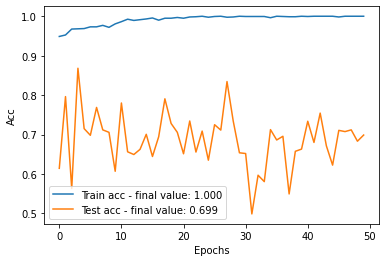

In [ ]:
acc = finetunig_2.history.history["acc"]; val_acc = finetunig_2.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


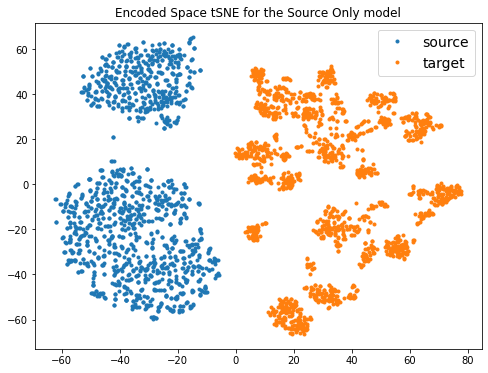

In [ ]:
LC25000_train_data_enc = finetunig_2.transform(LC25000_train_data_ex)
TCGA_train_data_enc = finetunig_2.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig_2.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,50.000000,50.000000,50.000000,50.000000
mean,0.024189,0.991575,2.453044,0.687400
std,0.036988,0.012983,1.050021,0.068766
min,0.000004,0.948750,0.543548,0.498750
25%,0.000807,0.990313,1.823443,0.652344
50%,0.006672,0.998125,2.426408,0.696875
75%,0.027466,0.999844,3.104473,0.714375
max,0.151426,1.000000,5.309937,0.868125


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_512/MDD_source_Resnet_512_RMS_1e-5.csv")

# Fit with adaptation

### Run 1

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = SGD(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = SGD(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)
optimizer_disc = SGD(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
200/200 [==============================] - 10s 51ms/step - loss: 0.0759 - acc: 0.9737 - disc_loss: 0.4413 - val_loss: 0.5574 - val_acc: 0.7894
Epoch 2/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0727 - acc: 0.9762 - disc_loss: 0.4327 - val_loss: 0.5416 - val_acc: 0.7962
Epoch 3/200
200/200 [==============================] - 9s 45ms/step - loss: 0.0698 - acc: 0.9781 - disc_loss: 0.4437 - val_loss: 0.5483 - val_acc: 0.7925
Epoch 4/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0768 - acc: 0.9762 - disc_loss: 0.4346 - val_loss: 0.5437 - val_acc: 0.7956
Epoch 5/200
200/200 [==============================] - 9s 45ms/step - loss: 0.0745 - acc: 0.9775 - disc_loss: 0.4530 - val_loss: 0.5480 - val_acc: 0.7937
Epoch 6/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0779 - acc: 0.9731 - disc_loss: 0.4499 - val_loss: 0.5573 - val_acc: 0.7912
Epoch 7/200
200/200 [==============================] - 9s 44ms/step - loss:

### Run 2 


In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = SGD(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = SGD(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)
optimizer_disc = SGD(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
200/200 [==============================] - 10s 51ms/step - loss: 0.0588 - acc: 0.9819 - disc_loss: 0.3940 - val_loss: 0.6114 - val_acc: 0.7688
Epoch 2/200
200/200 [==============================] - 9s 46ms/step - loss: 0.0652 - acc: 0.9806 - disc_loss: 0.3870 - val_loss: 0.6182 - val_acc: 0.7663
Epoch 3/200
200/200 [==============================] - 9s 45ms/step - loss: 0.0629 - acc: 0.9787 - disc_loss: 0.3742 - val_loss: 0.6242 - val_acc: 0.7650
Epoch 4/200
200/200 [==============================] - 9s 45ms/step - loss: 0.0633 - acc: 0.9819 - disc_loss: 0.3832 - val_loss: 0.6051 - val_acc: 0.7719
Epoch 5/200
200/200 [==============================] - 9s 46ms/step - loss: 0.0537 - acc: 0.9837 - disc_loss: 0.3641 - val_loss: 0.6484 - val_acc: 0.7538
Epoch 6/200
200/200 [==============================] - 9s 46ms/step - loss: 0.0624 - acc: 0.9787 - disc_loss: 0.3891 - val_loss: 0.6229 - val_acc: 0.7656
Epoch 7/200
200/200 [==============================] - 9s 46ms/step - loss:

### Run 3

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = SGD(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = SGD(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)
optimizer_disc = SGD(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
200/200 [==============================] - 10s 50ms/step - loss: 0.0892 - acc: 0.9681 - disc_loss: 0.5226 - val_loss: 0.6158 - val_acc: 0.7588
Epoch 2/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0929 - acc: 0.9631 - disc_loss: 0.5256 - val_loss: 0.6140 - val_acc: 0.7600
Epoch 3/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0882 - acc: 0.9706 - disc_loss: 0.5225 - val_loss: 0.6186 - val_acc: 0.7575
Epoch 4/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0891 - acc: 0.9719 - disc_loss: 0.5101 - val_loss: 0.6367 - val_acc: 0.7513
Epoch 5/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0827 - acc: 0.9725 - disc_loss: 0.5245 - val_loss: 0.6172 - val_acc: 0.7581
Epoch 6/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0942 - acc: 0.9663 - disc_loss: 0.5104 - val_loss: 0.6340 - val_acc: 0.7519
Epoch 7/200
200/200 [==============================] - 9s 44ms/step - loss:

### Run 4


In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = SGD(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = SGD(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)
optimizer_disc = SGD(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
200/200 [==============================] - 10s 52ms/step - loss: 0.0917 - acc: 0.9694 - disc_loss: 0.5049 - val_loss: 0.5772 - val_acc: 0.7694
Epoch 2/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0895 - acc: 0.9663 - disc_loss: 0.5100 - val_loss: 0.5757 - val_acc: 0.7700
Epoch 3/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0864 - acc: 0.9663 - disc_loss: 0.5079 - val_loss: 0.5795 - val_acc: 0.7713
Epoch 4/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0809 - acc: 0.9731 - disc_loss: 0.5056 - val_loss: 0.5755 - val_acc: 0.7725
Epoch 5/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0900 - acc: 0.9656 - disc_loss: 0.5098 - val_loss: 0.5689 - val_acc: 0.7750
Epoch 6/200
200/200 [==============================] - 9s 44ms/step - loss: 0.0900 - acc: 0.9725 - disc_loss: 0.5072 - val_loss: 0.5677 - val_acc: 0.7744
Epoch 7/200
200/200 [==============================] - 9s 44ms/step - loss:

### Run 5


In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = SGD(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = SGD(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)
optimizer_disc = SGD(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
import time

time. sleep(600)

In [ ]:
gc.collect()

1377

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
200/200 [==============================] - 10s 51ms/step - loss: 0.0893 - acc: 0.9700 - disc_loss: 0.4940 - val_loss: 0.6318 - val_acc: 0.7525
Epoch 2/200
200/200 [==============================] - 9s 45ms/step - loss: 0.0895 - acc: 0.9694 - disc_loss: 0.4949 - val_loss: 0.6187 - val_acc: 0.7569
Epoch 3/200
200/200 [==============================] - 9s 45ms/step - loss: 0.0793 - acc: 0.9756 - disc_loss: 0.4837 - val_loss: 0.6132 - val_acc: 0.7594
Epoch 4/200
200/200 [==============================] - 9s 45ms/step - loss: 0.0924 - acc: 0.9638 - disc_loss: 0.4887 - val_loss: 0.6265 - val_acc: 0.7544
Epoch 5/200
200/200 [==============================] - 9s 45ms/step - loss: 0.0848 - acc: 0.9688 - disc_loss: 0.4885 - val_loss: 0.6294 - val_acc: 0.7531
Epoch 6/200
200/200 [==============================] - 9s 45ms/step - loss: 0.0791 - acc: 0.9700 - disc_loss: 0.4729 - val_loss: 0.6211 - val_acc: 0.7550
Epoch 7/200
200/200 [==============================] - 9s 46ms/step - loss:

### Result

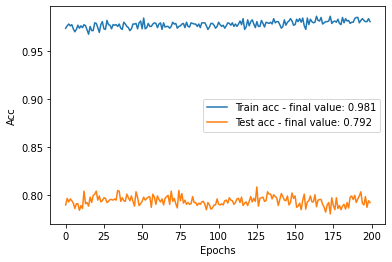

In [ ]:
acc = mdd.history.history["acc"]; val_acc = mdd.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


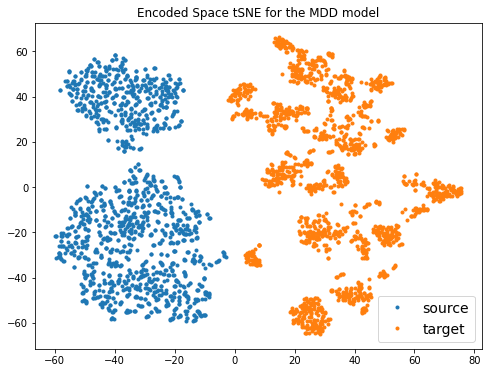

In [ ]:
LC25000_train_data_enc = mdd.transform(LC25000_train_data_ex)
TCGA_train_data_enc = mdd.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.066283,0.978025,0.363975,0.553871,0.793556
std,0.006848,0.003508,0.181014,0.011194,0.004921
min,0.045594,0.967500,0.072570,0.527782,0.780000
25%,0.061316,0.975625,0.220759,0.546113,0.790000
50%,0.066388,0.978125,0.327309,0.552931,0.793125
75%,0.071134,0.980156,0.476658,0.560906,0.796875
max,0.081632,0.986250,1.098264,0.589945,0.808125


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_512/MDD_Resnet_512_RMS_1e-5_g1.csv")

In [ ]:
import gc
gc.collect()

1270